### Model Evaluation & Interpretation

**Objective**:
The main objective of this process is to evaluate the best model i.e. Gradient Boosting using robust metrics and translate model outputs into business-actionable insights.



In [5]:
#Import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import  precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Load Data(From Engineered dataset)
df = pd.read_csv('C:\customerchurnprediction\data\engineered\engineeredbank_churn.csv')

#Drop Unnecessary columns
df.drop(columns=['gender', 'country'], inplace=True)

### Define Target and Features
x= df.drop(columns=['churn'])
y=df['churn']

### Define Features Group
#Different feature types need different preprocessing tenchniques
numerical_features = ['age', 'tenure','balance','credit_score','products_number',
                      'products_per_tenure','balance_per_product','churn_risk_score']
binary_features = ['credit_card','active_member','inactive_single_product',
                   'zero_balance','high_balance','early_customer']
categorical_features = ['age_group','credit_score_band']

### Train-Test Split(Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    x,y,test_size=0.2,random_state=42,stratify=y)

### Build Preprocessing Pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numerical_features),
    ('cat',categorical_pipeline, categorical_features)
],remainder='passthrough')

### Train Random Forest Model
rf = RandomForestClassifier(
    n_estimators = 300,
    max_depth = 8,
    min_samples_leaf = 50,
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
)

rf_pipeline = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('model', rf)
])

rf_pipeline.fit(X_train, y_train)

y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, y_proba_rf)

rf_auc

### Train Gradient Boosting Model
gb=GradientBoostingClassifier(
    n_estimators = 200,
    learning_rate = 0.05,
    max_depth = 3,
    random_state = 42
)

gb_pipeline = Pipeline(
    steps=[
        ('preprocessor',preprocessor),
        ('model', gb)
    ]
)

gb_pipeline.fit(X_train, y_train)

y_proba_gb =gb_pipeline.predict_proba(X_test)[:, 1]
gb_auc = roc_auc_score(y_test,y_proba_gb)

gb_auc

0.8515117582914193

##### 1. ROC CURVE Comparison with Visual Validation.
The ROC_AUC alon isn't sufficient to make a concusive receommendation. This is because it shows trade-offs across all thresholds.

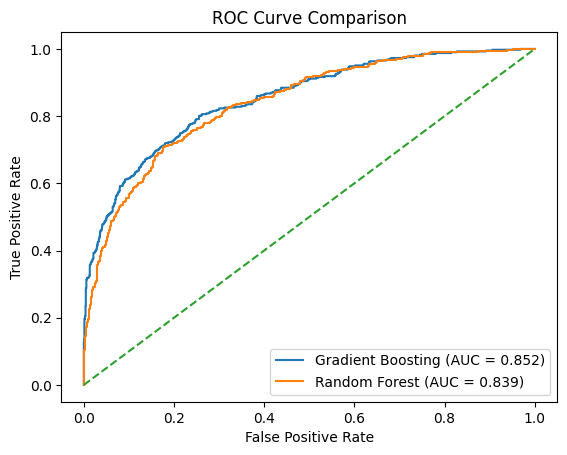

In [2]:
#Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)

#Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr_gb,tpr_gb, label= f'Gradient Boosting (AUC = {gb_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot([0, 1],[0, 1],linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### Interpretation

* Gradient Boosting dominates Random Forest across most thresholds
* Strong lift above the diagonal confirms **real predictive signal**
* Then it validates our model selection.

Precison-Recall Analysis(Taking care of imbalance)

As witnessed from our EDA, the churn data is imbalanced, therefore PR curves matter.

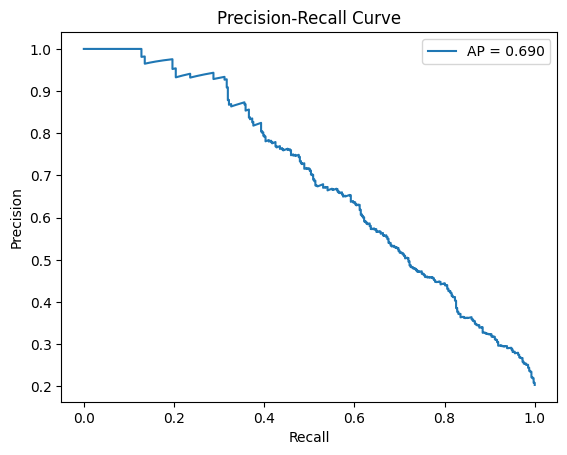

In [3]:
precision, recall, _ = precision_recall_curve(y_test, y_proba_gb)
ap = average_precision_score(y_test, y_proba_gb)

plt.figure()
plt.plot(recall, precision, label= f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### Interpretation

* The curve above shows how precison drops as recall increases.
* This curve helps us to select a business-appropriate operating threshold

### Threshold Selection(Business Driven)

Why 0.5 is wrong

* churn cost is not equal to retention cost
* At the same time missing churners is usually more expensive

In [4]:
thresholds = np.linspace(0.1, 0.9, 50)
metrics= []

for t in thresholds:
    preds = (y_proba_gb>= t).astype(int)
    metrics.append({
        'threshold': t,
        'precision':
precision_score(y_test, preds), 
        'recall': recall_score(y_test, preds)
    })

pd.DataFrame(metrics).head()

,threshold,precision,recall
0,0.100000,0.324181,0.899263
1,0.116327,0.353353,0.867322
2,0.132653,0.375973,0.830467
3,0.148980,0.414482,0.815725
4,0.165306,0.443989,0.798526


* From the resuts above, the typical threshold choice lies around **0.30-0.40**
* This produces high recall to catch at risk customers
* It's also an acceptable precision for targeted campaigns.

### Confusion Matrix at Selected Threshold

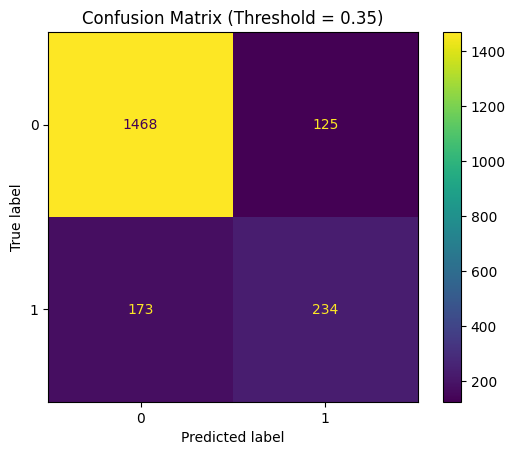

In [8]:
best_threshold = 0.35
y_pred_final = (y_proba_gb>= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_final)

ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix (Threshold = {best_threshold})')
plt.show()

* **1468 True Negatives**- churners correctly predicted to stay- Stable customers
* **234 True positives** - churners correctly identified
* **173 False Negatives** - churners the model missed(predited they'd stay)-(Costly)
* **125 False positives** - customers predicted to leave who actually stayed(unnecessarily flagged).


#### Feature Importance

In [10]:
gb_model = gb_pipeline.named_steps['model']
feature_names = gb_pipeline.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_model.feature_importances_
}).sort_values(by='importance', ascending= False)

importance_df.head(10)

,feature,importance
0,num__age,0.395988
4,num__products_number,0.293831
19,remainder__inactive_single_product,0.118168
17,remainder__active_member,0.049592
2,num__balance,0.035565
6,num__balance_per_product,0.025555
18,remainder__estimated_salary,0.019478
3,num__credit_score,0.019342
7,num__churn_risk_score,0.013438
20,remainder__zero_balance,0.008141


### Business Interpratation of Key Drivers

**Typical High-impact Features**

|Feature                     | Interpretation                            |
:---------------------------:|:-----------------------------------------:|
|IsActiveMember              | Inactive cusotmers churn more             |
|Age                         | Middle-aged customers show higher churn   |
|Balance                     | High balance + Low engagement = risk      |
|ProductsNumber              | Single-product customers churn more       |
|Geography/Location          | Region-specific churn behavior            |


The model identifies churn risk driven primarily by customer engagement product depth, and financial behavior. Cutstomers wuth low activity, limited product adoption, and disengaged transaction patterns exhibit significantly higher churn probability.